In [2]:
import os
from pygmid import Lookup as lk
import numpy as np
import matplotlib.pyplot as plt
from time import time
import matplotlib as mpl
path = '/home/pedersen/misc/gmid/configs_lv'

In [3]:
pmos_lv = lk(os.path.join(path, '130p1vrvt.pkl'))
nmos_lv = lk(os.path.join(path, '130n1vrvt.pkl'))

In [4]:
# setup mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams.update({"axes.grid" : True})

# Settings design parameters designing for weak inversion (i.e high effeciency)

In [10]:
# Specifications --------
Avo = 5 # DC gain
freq_pole = 1e6 #first pole
Cl = 1e-12 # load capacitance
Vdd = 1.2 # supply
# -----------------------
Ro = 1/(2*np.pi*freq_pole*Cl) 
gm = Avo/Ro


In [11]:
gmid = 10 #moderate inversion
i_tail = gm/gmid

# Choosing the channel length by quick overview

Here the focus is on getting a high intrinsic gain

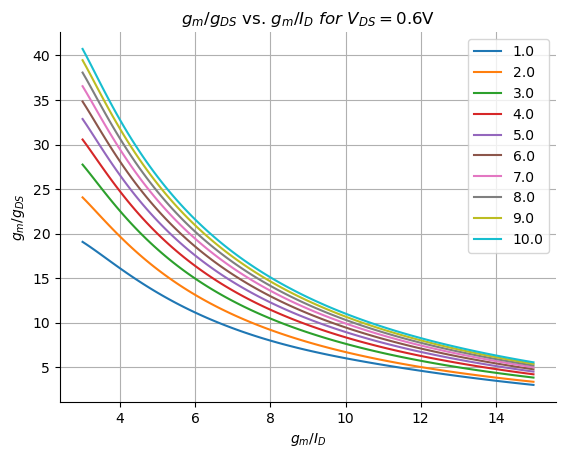

In [12]:
chosen_vds = 1.2/2  # i Choose half vdd to bias the output propally and get maximum output swing

# Now we plot the intrinsic gain to see if it's possible for our NMOS
gm_ids = np.arange(3, 15+0.1, 0.1)
Ls = [1.0,2.0,3.0,4.0,5.0,6.0, 7.0,8.0,9.0 ,10.0]

# Include the VDS parameter in the look_up function
gm_gds = nmos_lv.look_up('GM_GDS', GM_ID=gm_ids, L=Ls, VDS=chosen_vds, VSB = 0)

plt.figure()
plt.plot(gm_ids, gm_gds.T)
plt.ylabel(r"$g_m/g_{DS}$")
plt.xlabel(r"$g_m/I_D$")
plt.title(r'$g_m/g_{DS}$ vs. $g_m/I_D$ $for$ $V_{DS}=$' + str(chosen_vds) + 'V')
plt.legend(np.around(Ls, decimals=2))
plt.show()

# Selecting a specific L and gmid

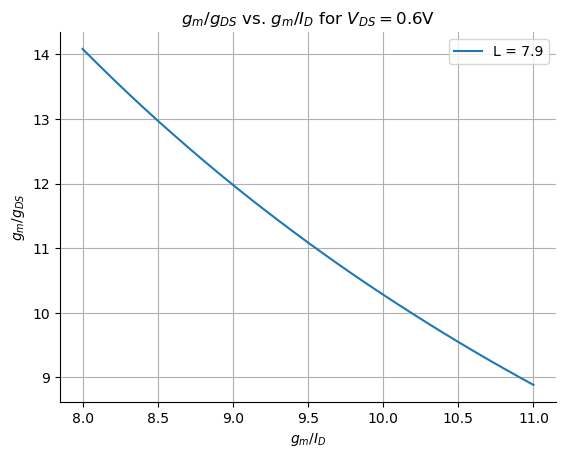

In [13]:
chosen_vds = 1.2 / 2
selected_L = 7.9 # fix my length
gm_ids = np.arange(8, 11 + 0.1, 0.1)
gm_gds = nmos_lv.look_up('GM_GDS', GM_ID=gm_ids, L=selected_L, VDS=chosen_vds, VSB=0)

plt.figure()
plt.plot(gm_ids, gm_gds.T)
plt.ylabel(r"$g_m/g_{DS}$")
plt.xlabel(r"$g_m/I_D$")
plt.title(r'$g_m/g_{DS}$ vs. $g_m/I_D$ for $V_{DS}=$' + str(chosen_vds) + 'V')
plt.legend([f'L = {selected_L}'])  # Set legend with selected_L
plt.show()

In [14]:
# We select the length of 7.19 to get gmro of approximatly 10
gmro = nmos_lv.look_up('GM_GDS', GM_ID=10, L=selected_L, VDS=chosen_vds, VSB = 0)

#now the intrinsic impedance is given as
ro = gmro/gm

# and from here we can decide the load resistance
R_L = 1/((1/Ro)-(1/ro))


# Finding MOS dimensions from gmid and channel length

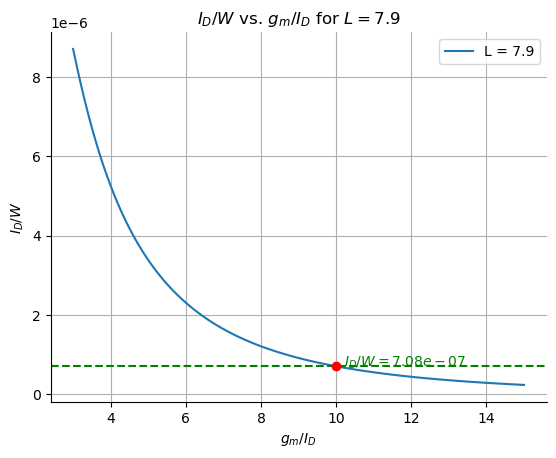

In [15]:
selected_gm_id = gmid
id_w_value = nmos_lv.look_up('ID_W', GM_ID=selected_gm_id, L=selected_L, VDS=chosen_vds)
plt.figure()
gm_ids = np.arange(3, 15+0.1, 0.1)
id_w = nmos_lv.look_up('ID_W', GM_ID=gm_ids, L=selected_L, VDS=chosen_vds)
plt.plot(gm_ids, id_w, label=f'L = {selected_L}')

plt.axhline(y=id_w_value, color='green', linestyle='--', label=f"$I_D/W={id_w_value:.2e}$")
plt.plot(selected_gm_id, id_w_value, 'ro')  
plt.text(selected_gm_id + 0.2, id_w_value, f"$I_D/W={id_w_value:.2e}$", color='green')
plt.ylabel(r"$I_D/W$")
plt.xlabel(r"$g_m/I_D$")
plt.title(rf'$I_D/W$ vs. $g_m/I_D$ for $L = {selected_L}$')
plt.legend([f'L = {selected_L}']) 
plt.show()

In [16]:
width = i_tail/id_w_value
width = str(round(width, 5))
print('the width is given as Id/(Id/W): ' + str(width) + 'µm')
print('the length is given as: ' + str(selected_L) + 'µm')
print('the tail current is given as: ' + str(round((i_tail*1e6),4)) + 'µA')
print('the load impedance is given as: ' + str(R_L) + ' Ohms')

the width is given as Id/(Id/W): 4.43934µm
the length is given as: 7.9µm
the tail current is given as: 3.1416µA
the load impedance is given as: 309848.81871487683 Ohms
